## The question of interest

Are there trends in FDA recalls?

## Getting the data

In [206]:
import pandas as pd
#import pandas.io.data
import pandas_datareader.data
import numpy as np
import datetime
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 8)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 4)

%matplotlib inline

import pylab
pylab.rcParams['figure.figsize'] = (8.0, 6.0)

import requests
import json
from xml.etree import ElementTree

import html

In [13]:
r = requests.get("http://www.healthdata.gov/api/3/action/package_show?id=18711")
jsonResponse = json.loads(r.text)
print (json.dumps(jsonResponse, indent=1))

{
 "result": [
  {
   "name": "all-fda-recalls",
   "groups": [
    {
     "id": "af7749f7-beeb-453f-97e7-c958adeb40dc",
     "image_display_url": "http://www.healthdata.gov/sites/default/files/US-DeptOfHHS-Seal1_0.jpg",
     "title": "Department of Health &amp; Human Services",
     "name": "group/department-health-human-services",
     "description": "<p>The United States Department of Health and Human Services (HHS), also known as the Health Department, is a cabinet-level department of the U.S. federal government with the goal of protecting the health of all Americans and providing essential human services. The official HHS motto is \"Improving the health, safety, and well-being of America.\"</p>\n"
    }
   ],
   "metadata_created": "Tue, 03/31/2015 - 21:09",
   "resources": [
    {
     "revision_id": "",
     "resource_group_id": "",
     "name": "http://www.fda.gov/DataSets/Recalls/RecallsDataSet.xml",
     "created": "Fri, 05/08/2015 - 16:17",
     "size": "",
     "description

In [159]:
r.encoding

'ISO-8859-1'

In [22]:
r = requests.get("http://www.fda.gov/DataSets/Recalls/RecallsDataSet.xml")

In [161]:
r.encoding

'utf-8'

In [164]:
r.encoding = 'ISO-8859-1'
r.encoding = 'utf-8'

Make sure information is downloaded

In [165]:
r.text

'<?xml version="1.0" encoding="UTF-8" ?>\r\n\r\n\r\n\r\n\t\r\n\r\n<RECALLS_DATA>\r\n<PRODUCT>\r\n\t<DATE>Thu, 17 Mar 2016 11:47:00 -0400</DATE>\r\n\t<BRAND_NAME><![CDATA[Chicken of the Sea]]></BRAND_NAME>\r\n\t<PRODUCT_DESCRIPTION><![CDATA[Canned tuna]]></PRODUCT_DESCRIPTION>\r\n\t<REASON><![CDATA[Product may be contaminated by spoilage organisms or pathogens, which could lead to life-threatening\r\nillness if consumed]]></REASON>\r\n\t<COMPANY><![CDATA[Tri-Union Seafoods, LLC]]></COMPANY>\r\n\t<COMPANY_RELEASE_LINK>http://www.fda.gov/Safety/Recalls/ucm491206.htm</COMPANY_RELEASE_LINK>\r\n\t<PHOTOS_LINK>\t</PHOTOS_LINK>\r\n</PRODUCT>\r\n<PRODUCT>\r\n\t<DATE>Wed, 16 Mar 2016 20:23:00 -0400</DATE>\r\n\t<BRAND_NAME><![CDATA[Bumble Bee]]></BRAND_NAME>\r\n\t<PRODUCT_DESCRIPTION><![CDATA[Canned tuna]]></PRODUCT_DESCRIPTION>\r\n\t<REASON><![CDATA[Product may be contaminated by spoilage organisms or pathogens, which could lead to life-threatening illness if consumed]]></REASON>\r\n\t<COMPANY><

## Cleaning the data

Convert to xml tree

In [26]:
tree = ElementTree.fromstring(r.text)

In [37]:
tree.getchildren()

[<Element 'PRODUCT' at 0x10f506868>,
 <Element 'PRODUCT' at 0x10f506d18>,
 <Element 'PRODUCT' at 0x10f50a048>,
 <Element 'PRODUCT' at 0x10f50a368>,
 <Element 'PRODUCT' at 0x10f50a638>,
 <Element 'PRODUCT' at 0x10f50a908>,
 <Element 'PRODUCT' at 0x10f50abd8>,
 <Element 'PRODUCT' at 0x10f50aef8>,
 <Element 'PRODUCT' at 0x10f50c278>,
 <Element 'PRODUCT' at 0x10f50c548>,
 <Element 'PRODUCT' at 0x10f50c818>,
 <Element 'PRODUCT' at 0x10f50c9f8>,
 <Element 'PRODUCT' at 0x10f50cd18>,
 <Element 'PRODUCT' at 0x10f50d048>,
 <Element 'PRODUCT' at 0x10f50d368>,
 <Element 'PRODUCT' at 0x10f50d6d8>,
 <Element 'PRODUCT' at 0x10f50d9a8>,
 <Element 'PRODUCT' at 0x10f50dcc8>,
 <Element 'PRODUCT' at 0x10f50df98>,
 <Element 'PRODUCT' at 0x10f50e368>,
 <Element 'PRODUCT' at 0x10f50e638>,
 <Element 'PRODUCT' at 0x10f50e908>,
 <Element 'PRODUCT' at 0x10f50ebd8>,
 <Element 'PRODUCT' at 0x10f50eea8>,
 <Element 'PRODUCT' at 0x10f50f278>,
 <Element 'PRODUCT' at 0x10f50f548>,
 <Element 'PRODUCT' at 0x10f50f818>,
 

It looks like everything is stored under PRODUCT.
What information is stored in there?

In [70]:
list = {}
for product in tree.getchildren():
    for desc in product.getchildren():
        list[desc.tag] = ""
print (list.keys())

dict_keys(['DATE', 'BRAND_NAME', 'COMPANY_RELEASE_LINK', 'COMPANY', 'PRODUCT_DESCRIPTION', 'PHOTOS_LINK', 'REASON'])


Lets store this in a Pandas dataframe

In [376]:
rows_list = []

def check_xml_tag(parent, tagname):
    tag = parent.find(tagname)
    try:
        if len(tag.text.lstrip().rstrip()) == 0:
            return None
        if tagname == 'REASON':
            return html.unescape(tag.text.lstrip().rstrip()).title()
        else:
            return html.unescape(tag.text.lstrip().rstrip())
    except: 
        return None
    
# for product in tree.iter('PRODUCT'): # May be too specific
for product in tree.getchildren():
    # print(product.tag) # just the PRODUCT tag. No attrib in this XML
    # ElementTree.dump(product) # This dumps the contents 
    date = check_xml_tag(product, 'DATE')
    brand_name = check_xml_tag(product, 'BRAND_NAME')
    desc = check_xml_tag(product, 'PRODUCT_DESCRIPTION')
    reason = check_xml_tag(product, 'REASON')
    company = check_xml_tag(product, 'COMPANY')
    release_link = check_xml_tag(product, 'COMPANY_RELEASE_LINK')
    photo_link = check_xml_tag(product, 'PHOTOS_LINK')
#     test_empty = check_xml_tag(product, 'DOESNT_EXIST')
#     print(",".join(date.split()[1:5]))
    datedt = datetime.datetime.strptime(",".join(date.split()[1:5]), "%d,%b,%Y,%H:%M:%S")
    
    rows_list.append({"Date": datedt,
                      "Brand": brand_name,
                      "Description": desc,
                      "Reason": reason,
                      "Company": company,
                      "Release": release_link,
                      "Photo": photo_link})

# print(datetime.datetime.strftime(datetime.datetime.now(),"%d,%b,%Y,%H:%M:%s")  )  
recalls = pd.DataFrame(rows_list)
recalls = recalls.fillna(value=np.nan)
recalls

,Brand,Company,Date,Description,Photo,Reason,Release
0,Chicken of the Sea,"Tri-Union Seafoods, LLC",2016-03-17 11:47:00,Canned tuna,NaN,Product May Be Contaminated By Spoilage Organi...,http://www.fda.gov/Safety/Recalls/ucm491206.htm
1,Bumble Bee,"Bumble Bee Foods, LLC",2016-03-16 20:23:00,Canned tuna,NaN,Product May Be Contaminated By Spoilage Organi...,http://www.fda.gov/Safety/Recalls/ucm491107.htm
2,Ashland Food Co-op,Ashland Food Co-op,2016-03-16 17:14:00,Organic raw macadamia nuts,NaN,Salmonella,http://www.fda.gov/Safety/Recalls/ucm491100.htm
3,"Nature's Eats, Southern Grove, Fresh Choice","Texas Star Nut and Food Co., Inc.",2016-03-14 09:29:00,Pistachios and mixes containing pistachios,NaN,Salmonella,http://www.fda.gov/Safety/Recalls/ucm490751.htm
4,Arrow,Teleflex Incorporated,2016-03-11 10:09:00,Intra-Aortic Balloon Catheter Kits and Percuta...,NaN,The Sheath Body May Become Separated From The ...,http://www.fda.gov/Safety/Recalls/ucm490318.htm
...,...,...,...,...,...,...,...
3487,King Nut,King Nut,2009-01-12 00:00:00,Peanut Butter,NaN,Salmonella,http://www.fda.gov/Safety/Recalls/ArchiveRecal...
3488,Cafï¿½ Favorites,Cafï¿½ Favorites,2009-01-10 00:00:00,Sandwich,NaN,Listeria Monocytogenes,http://www.fda.gov/Safety/Recalls/ArchiveRecal...
3489,Peanut Corporation of America,King Nut,2009-01-10 00:00:00,Peanut Butter,http://www.fda.gov/Safety/Recalls/ArchiveRecal...,Salmonella,http://www.fda.gov/Safety/Recalls/ArchiveRecal...
3490,Charlie's,Triple B Corporation dba S.T.,2009-01-09 00:00:00,Yogurt Parfait,NaN,Allergen,http://www.fda.gov/Safety/Recalls/ArchiveRecal...


## Exploring the data

In [377]:
recalls.columns

Index(['Brand', 'Company', 'Date', 'Description', 'Photo', 'Reason',
       'Release'],
      dtype='object')

In [378]:
recalls.describe()

,Brand,Company,Date,Description,Photo,Reason,Release
count,3466,3486,3492,3457,1591,3485,3492
unique,2735,2504,2315,2143,1577,895,3492
top,Whole Foods Market,Whole Foods Market,2009-02-03 00:00:00,Ice Cream,http://www.fda.gov/Safety/Recalls/ucm272269.htm,Salmonella,http://www.fda.gov/Safety/Recalls/ucm240168.htm
freq,27,60,41,98,2,1165,1
first,NaN,NaN,2009-01-05 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-03-17 11:47:00,NaN,NaN,NaN,NaN


In [379]:
recalls.dtypes

Brand                  object
Company                object
Date           datetime64[ns]
Description            object
Photo                  object
Reason                 object
Release                object
dtype: object

### Question: Has the rate of recalls increased over time?

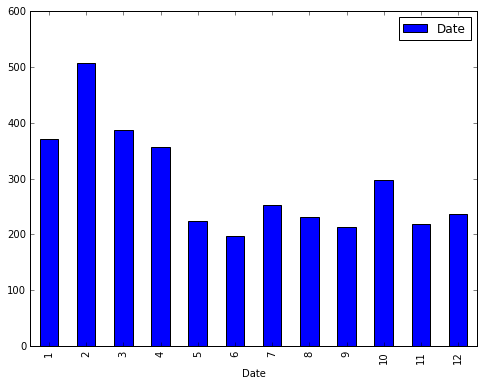

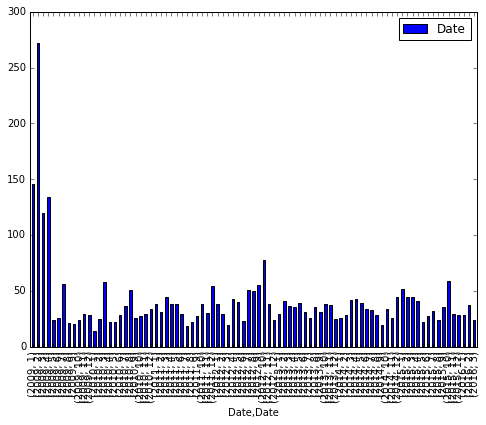

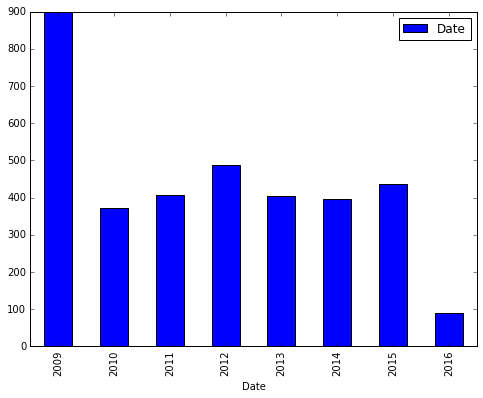

In [380]:
dates = recalls[['Date']]
dates.groupby(dates.Date.dt.month).count().plot(kind="bar")
dates.groupby([dates.Date.dt.year ,dates.Date.dt.month]).count().plot(kind="bar")
dates.groupby(dates.Date.dt.year).count().plot(kind="bar")

It seems like there was the most recalls in 2009.  This may be due to inclusion of data prior to 2009 using 2009 as the date.

### Question: What is the distribution of Brands recalled?  What is the top?

In [381]:
brandgroup = recalls.groupby(recalls.Brand).count()
# .plot(kind="bar")
brandgroup['Date'].nlargest(10)


Brand
Whole Foods Market    27
Hospira               26
Whole Foods           20
American Regent       18
Wegmans               17
Publix                16
Baxter                13
Kroger                13
Fresh Express         12
Giant Eagle           12
Name: Date, dtype: int64

In [382]:
company_group = recalls.groupby(recalls.Company).count()
# .plot(kind="bar")
company_group['Date'].nlargest(10)

Company
Whole Foods Market            60
Hospira, Inc.                 35
The Kroger Co.                20
Baxter International Inc.     15
General Mills                 12
Giant Eagle                   12
Wegmans Food Markets, Inc.    12
McNeil Consumer Healthcare    11
American Regent, Inc.         10
Rich Products Corporation     10
Name: Date, dtype: int64

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


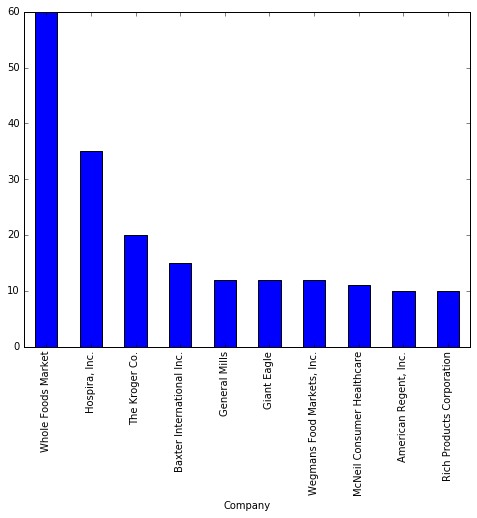

In [418]:
# company_group.hist()
print(type(company_group))
print(type(company_group['Date'].nlargest(10)))
company_group['Date'].nlargest(10).plot(kind="bar")

In [384]:
whole_foods = recalls[recalls.Company == "Whole Foods Market"]
whole_foods

,Brand,Company,Date,Description,Photo,Reason,Release
24,Maytag,Whole Foods Market,2016-02-29 00:00:00,Blue cheese,NaN,Listeria Monocytogenes,http://www.fda.gov/Safety/Recalls/ucm488391.htm
42,"Whole Foods Market, Mitica",Whole Foods Market,2016-02-16 17:56:00,Cheese,NaN,Listeria Monocytogenes,http://www.fda.gov/Safety/Recalls/ucm486410.htm
167,Whole Foods Market North Atlantic Kitchens,Whole Foods Market,2015-10-23 21:07:00,Bulk and Packaged Salads,NaN,Listeria Monocytogenes,http://www.fda.gov/Safety/Recalls/ucm469008.htm
196,Whole Foods Market,Whole Foods Market,2015-10-07 20:03:00,Papillon Organic Roquefort Cheeses,http://www.fda.gov/Safety/Recalls/ucm466186.htm,Listeria Monocytogenes,http://www.fda.gov/Safety/Recalls/ucm466185.htm
268,Whole Foods,Whole Foods Market,2015-07-30 00:00:00,Coconut Curry Cauliflower Salad,http://www.fda.gov/Safety/Recalls/ucm456871.htm,Undeclared Almonds,http://www.fda.gov/Safety/Recalls/ucm456869.htm
...,...,...,...,...,...,...,...
3073,Glory Bee Foods,Whole Foods Market,2009-03-01 00:00:00,"Peanuts, Snack Mix",NaN,Salmonella,http://www.fda.gov/Safety/Recalls/ArchiveRecal...
3150,Whole Foods,Whole Foods Market,2009-02-13 00:00:00,Peanut Butter,NaN,Salmonella,http://www.fda.gov/Safety/Recalls/ArchiveRecal...
3237,Whole Foods,Whole Foods Market,2009-02-05 00:00:00,"Peanuts, Peanut Butter, Snack Food",NaN,Salmonella,http://www.fda.gov/Safety/Recalls/ArchiveRecal...
3253,Whole Foods,Whole Foods Market,2009-02-04 00:00:00,"Peanuts, Peanut Butter",NaN,Salmonella,http://www.fda.gov/Safety/Recalls/ArchiveRecal...


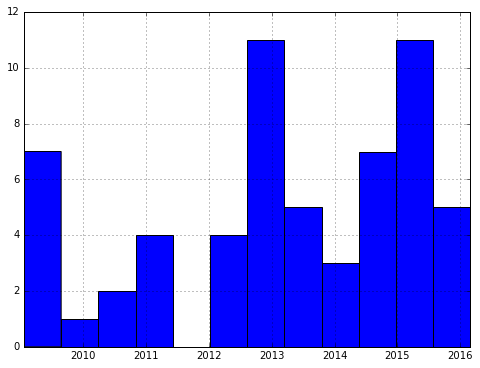

In [392]:
whole_foods.Date.hist(bins=12)

Not sure what the above plot really means. The years are not evenly dispersed.

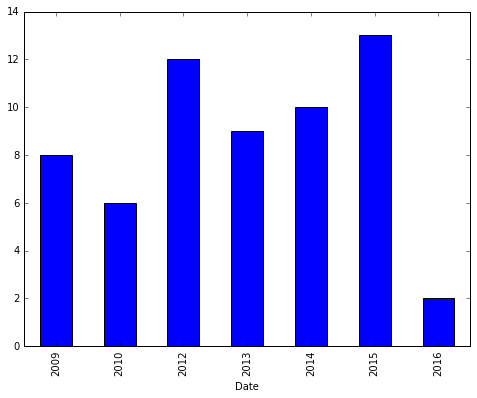

In [386]:
whole_foods.Date.groupby(dates.Date.dt.year).count().plot(kind="bar")

Find all companies starting with "C" and sort aphabetically

In [387]:
c_companies = recalls[recalls.Company.str[0] == "C"]
# c_companies.sort(['Company'], ascending=[1])
c_companies.sort_values(by=['Company'], ascending=[1])

,Brand,Company,Date,Description,Photo,Reason,Release
3135,"Aunt Patty's, C & K Market","C & K Market, Inc.",2009-02-17 00:00:00,"Peanuts, Snack Mix",NaN,Salmonella,http://www.fda.gov/Safety/Recalls/ArchiveRecal...
2509,"Sunbird, Williams","C.H. Guenther & Son, Inc.",2010-03-17 15:43:00,Seasoning Mixes,http://www.fda.gov/Safety/Recalls/ucm205417.htm,Salmonella,http://www.fda.gov/Safety/Recalls/ArchiveRecal...
2507,Chilli Man,"C.H. Guenther & Son, Inc.",2010-03-18 13:48:00,Seasoning Mix,http://www.fda.gov/Safety/Recalls/ucm206206.htm,Salmonella,http://www.fda.gov/Safety/Recalls/ArchiveRecal...
2503,"Bayou, Shop'n Save, Carlita, more","C.H. Guenther & Son, Inc.",2010-03-22 17:15:00,"Seasoning Mixes, Gravy Mixes",NaN,Salmonella,http://www.fda.gov/Safety/Recalls/ArchiveRecal...
2501,"Best Yet, Food Club, Tops, more","C.H. Guenther & Son, Inc.",2010-03-23 13:02:00,"Seasoning Mixes, Gravy Mixes",NaN,Salmonella,http://www.fda.gov/Safety/Recalls/ArchiveRecal...
...,...,...,...,...,...,...,...
129,Custom Ultrasonics,Custom Ultrasonics,2015-11-16 15:36:00,Automated Endoscope Reprocessors (AERs),NaN,Increased Risk Of Infection Transmission,http://www.fda.gov/Safety/Recalls/ucm472940.htm
579,Customed,"Customed, Inc.",2014-11-21 00:00:00,Sterile Convenience Surgical Kits,NaN,Potential Package Integrity Defect That May Co...,http://www.fda.gov/Safety/Recalls/ucm424718.htm
663,Customed,"Customed, Inc.",2014-08-21 00:00:00,Hospital Surgical Packs,http://www.fda.gov/Safety/Recalls/ucm411793.htm,Adhesion Defect Which Could Result In Loss Of ...,http://www.fda.gov/Safety/Recalls/ucm411442.htm
1504,H. Brooks &amp Company,Cut Fruit Express Inc.,2012-09-13 00:00:00,Fresh cut fruit products containing cantaloupes,NaN,Due To Potential Contamination With Salmonella,http://www.fda.gov/Safety/Recalls/ucm319523.htm


In [402]:
reasons = recalls.groupby(recalls.Reason).count()
# .plot(kind="bar")
reasons['Date'].nlargest(30)

Reason
Salmonella                                    1165
Listeria Monocytogenes                         345
Undeclared Milk                                158
Allergen                                        97
Undeclared Peanuts                              71
                                              ... 
Sulfites                                         8
Undeclared Ingredient, Unapproved New Drug       8
Undeclared Pecans                                8
Aflatoxin                                        7
Lack Of Assurance Of Sterility                   7
Name: Date, dtype: int64

In [389]:
reasons.describe()

,Brand,Company,Date,Description,Photo,Release
count,895.0000,895.0000,895.0000,895.0000,895.0000,895.0000
mean,3.8715,3.8939,3.8939,3.8592,1.7765,3.8939
std,41.0274,41.2260,41.2260,40.9340,14.5748,41.2260
min,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000
25%,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000
50%,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
75%,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
max,1159.0000,1165.0000,1165.0000,1157.0000,364.0000,1165.0000


In [397]:
# reasons.hist(ax=['Reason'])
type(reasons['Date'].nlargest(30))

pandas.core.series.Series

In [400]:
np.histogram(reasons['Date'].nlargest(30)).

(array([27,  1,  1,  0,  0,  0,  0,  0,  0,  1]),
 array([    7. ,   122.8,   238.6,   354.4,   470.2,   586. ,   701.8,
          817.6,   933.4,  1049.2,  1165. ]))

In [415]:
print(type(recalls.groupby(recalls.Reason)))
print(type(recalls.groupby(recalls.Reason).count()))
print(type(recalls.groupby(recalls.Reason).count()['Date'].nlargest(10)))
# recalls.groupby(recalls.Reason).count()

<class 'pandas.core.groupby.DataFrameGroupBy'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


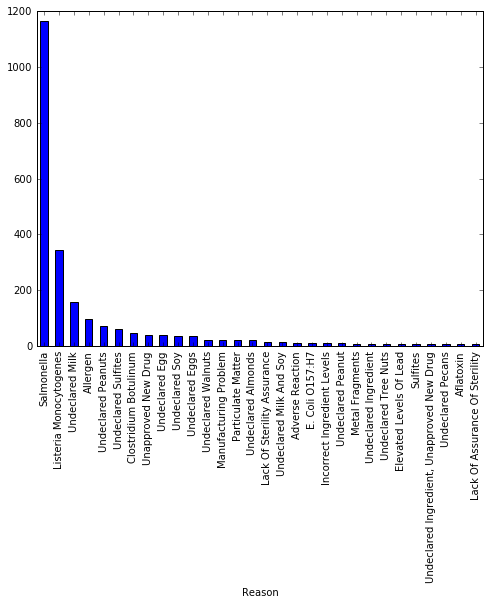

In [416]:
top_reasons = recalls.groupby(recalls.Reason).count()['Date'].nlargest(30)
top_reasons.plot(kind='bar')